In [23]:
%matplotlib inline

import sys
import os
import logging
import ast
import re

import numpy as np
import pandas as pd
from scipy import stats
from scipy.special import rel_entr
from copy import copy, deepcopy

from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from matplotlib.text import Annotation
plt.style.use('default')

In [37]:
def set_style(fsz=14):
    # sns.set_context("paper")
    plt.rc('font', family='Linux Libertine')
    # sns.set_style("ticks", {"xtick.major.size": 3, "ytick.major.size": 3})
    
    plt.rc('font', size=fsz, family='Serif')
    plt.rc('axes', titlesize=fsz)
    plt.rc('axes', labelsize=fsz)
    plt.rc('xtick', labelsize=fsz)
    plt.rc('ytick', labelsize=fsz)
    plt.rc('legend', fontsize=fsz)
    plt.rc('figure', titlesize=fsz)
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    
def set_size(fig, width=3.33, height=2, scale=1):
    fig.set_size_inches(width * scale, height * scale)
    
VIZ_DIR = "/Users/ndhuynh/sandbox/viz/"
def save_fig(fig, filename):
    fig.savefig(VIZ_DIR + filename, dpi=300, format='pdf', bbox_inches='tight')
    
class Annotation3D(Annotation):

    def __init__(self, text, xyz, *args, **kwargs):
        super().__init__(text, xy=(0, 0), *args, **kwargs)
        self._xyz = xyz

    def draw(self, renderer):
        x2, y2, z2 = proj_transform(*self._xyz, self.axes.M)
        self.xy = (x2, y2)
        super().draw(renderer)

def _annotate3D(ax, text, xyz, *args, **kwargs):
    '''Add anotation `text` to an `Axes3d` instance.'''

    annotation = Annotation3D(text, xyz, *args, **kwargs)
    ax.add_artist(annotation)

setattr(Axes3D, 'annotate3D', _annotate3D)

In [38]:
sys.path.insert(1, '/Users/ndhuynh/repos/endure/endure/endure')
from data.data_provider import DataProvider
from data.data_exporter import DataExporter
from robust.workload_uncertainty import WorkloadUncertainty
from lsm_tree.cost_function import CostFunction
from lsm_tree.nominal import NominalWorkloadTuning
from jobs.sample_uncertain_workloads import SampleUncertainWorkloads

config = DataProvider.read_config('/Users/ndhuynh/repos/endure/endure/endure/config/robust-lsm-trees.yaml')
de = DataExporter(config)
dp = DataProvider(config)
w0s = [
    {'z0': 0.25, 'z1': 0.25, 'q': 0.25, 'w': 0.25},     # 00
    {'z0': 0.97, 'z1': 0.01, 'q': 0.01, 'w': 0.01},     # 01
    {'z0': 0.01, 'z1': 0.97, 'q': 0.01, 'w': 0.01},     # 02
    {'z0': 0.01, 'z1': 0.01, 'q': 0.97, 'w': 0.01},     # 03
    {'z0': 0.01, 'z1': 0.01, 'q': 0.01, 'w': 0.97},     # 04
    {'z0': 0.49, 'z1': 0.49, 'q': 0.01, 'w': 0.01},     # 01
    {'z0': 0.49, 'z1': 0.01, 'q': 0.49, 'w': 0.01},     # 06
    {'z0': 0.49, 'z1': 0.01, 'q': 0.01, 'w': 0.49},     # 07
    {'z0': 0.01, 'z1': 0.49, 'q': 0.49, 'w': 0.01},     # 08
    {'z0': 0.01, 'z1': 0.49, 'q': 0.01, 'w': 0.49},     # 09
    {'z0': 0.01, 'z1': 0.01, 'q': 0.49, 'w': 0.49},     # 10
    {'z0': 0.33, 'z1': 0.33, 'q': 0.33, 'w': 0.01},     # 11
    {'z0': 0.33, 'z1': 0.33, 'q': 0.01, 'w': 0.33},     # 12
    {'z0': 0.33, 'z1': 0.01, 'q': 0.33, 'w': 0.33},     # 13
    {'z0': 0.01, 'z1': 0.33, 'q': 0.33, 'w': 0.33},     # 14
    {'z0': 0.10, 'z1': 0.10, 'q': 0.10, 'w': 0.70},     # 15
    {'z0': 0.70, 'z1': 0.20, 'q': 0.01, 'w': 0.01},     # 16
    {'z0': 0.30, 'z1': 0.05, 'q': 0.05, 'w': 0.60},     # 17
]
combine_reads = lambda w: {'z': w['z0'] + w['z1'], 'q': w['q'], 'w': w['w']}
w0s = list(map(combine_reads, w0s))
to_array = lambda w: [w['z'], w['q'], w['w']]
samples = list(map(combine_reads, SampleUncertainWorkloads(config).get_uncertain_samples(10000)))

In [39]:
workloads = []
for wl in samples:
    row = wl
    wl = to_array(wl)
    for wl_id, w0 in enumerate(w0s):
        w0 = to_array(w0)
        row[f'd{wl_id}'] = np.sum(rel_entr(wl, w0))
    workloads.append(row)

df = pd.DataFrame(workloads)

In [40]:
x, y = np.linspace(0, 1, 11), np.linspace(1, 0, 11)
x, y = np.meshgrid(x, y)
z = 1 - (x + y)
x[z < 0] = y[z < 0] = z[z < 0] = 0
x = x.transpose() + np.tril(x, -1)
y = y.transpose() + np.tril(y, -1)
z = z.transpose() + np.tril(z, -1)

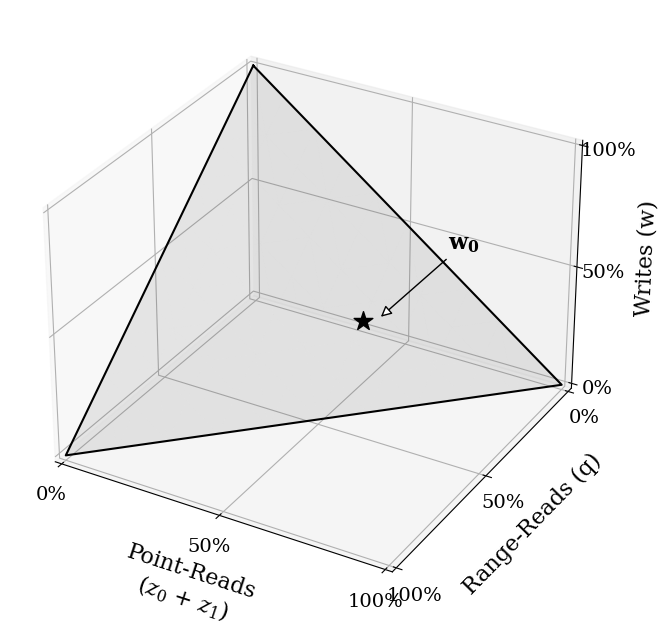

In [54]:
w0id, left, right = 0, 0, 0.2
fs = 16
w0 = to_array(w0s[w0id]) 
df_obs = df[(df[f'd{w0id}'] > left) & (df[f'd{w0id}'] < right)]

set_style()
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
fig.add_axes(ax)

ax_surf = ax.plot_trisurf(x.flatten(), y.flatten() , z.flatten(), color='tab:gray', alpha=0.1, zorder=0, rasterized=True)
# cloud = ax.plot_trisurf(df_obs['z'], df_obs['q'], df_obs['w'], color='tab:green', alpha=0.5, zorder=2, rasterized=True)
edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)
ax_w0 = ax.scatter(w0[0], w0[1], w0[2], color='black', marker='*', s=200, zorder=100, rasterized=True)
# fakeline = mpl.lines.Line2D([0],[0], linestyle="none", c='tab:green', marker = 'o', alpha=0.5)
# ax.legend([fakeline], ['Uncertainty Neighborhood'], loc='upper right')

ax.set_xlim3d(0, 1), ax.set_ylim3d(0, 1), ax.set_zlim3d(0, 1)
ax.set_xticks([0, 0.5, 1], fontsize=fs), ax.set_yticks([0, 0.5, 1], fontsize=fs), ax.set_zticks([0, 0.5, 1], fontsize=fs)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax.set_ylim(1, 0)
ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15, fontsize=fs)
ax.set_ylabel('Range-Reads (q)', labelpad=10, fontsize=fs)
ax.set_zlabel('Writes (w)', labelpad=10, fontsize=fs)

ax.annotate3D('$\mathbf{w_0}$', (0.55, 0.25, 0.28),
              xytext=(50, 50),
              textcoords='offset points',
              fontsize=fs,
              arrowprops=dict(arrowstyle="-|>", ec='black', fc='white', lw=1))

# df_obs = df_obs.sort_values(by='d0')
# df_obs = df_obs[df_obs.z < 0.3]
# ptmax = df_obs.iloc[-1]
# ax.plot([w0[0], ptmax.z], [w0[1], ptmax.q], [w0[2], ptmax.w], '--', color='black', lw=2)
# ax.text(0.4, 0.35, 0.45, r'$\rho = 0.2$')
set_size(fig, scale=3)
save_fig(fig, 'kl_div.pdf')

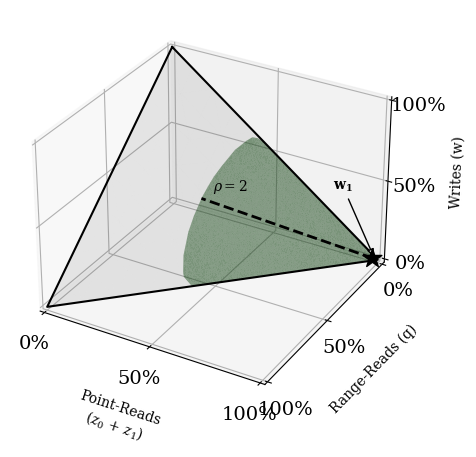

In [48]:
w0id, left, right = 1, 0, 2
w0 = to_array(w0s[w0id]) 
df_obs = df[(df[f'd{w0id}'] > left) & (df[f'd{w0id}'] < right)]

set_style()
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
fig.add_axes(ax)

ax_surf = ax.plot_trisurf(x.flatten(), y.flatten() , z.flatten(), color='tab:gray', alpha=0.1, zorder=0, rasterized=True)
cloud = ax.plot_trisurf(df_obs['z'], df_obs['q'], df_obs['w'], color='tab:green', alpha=0.5, zorder=2, rasterized=True)
edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)
ax_w0 = ax.scatter(w0[0], w0[1], w0[2], color='black', marker='*', s=200, zorder=100, rasterized=True)

ax.set_xlim3d(0, 1), ax.set_ylim3d(0, 1), ax.set_zlim3d(0, 1)
ax.set_xticks([0, 0.5, 1], fontsize=fs), ax.set_yticks([0, 0.5, 1], fontsize=fs), ax.set_zticks([0, 0.5, 1], fontsize=fs)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax.set_ylim(1, 0)
ax.set_xlabel('Point-Reads\n($z_0$ + $z_1$)', labelpad=15, fontsize=fs)
ax.set_ylabel('Range-Reads (q)', labelpad=10, fontsize=fs)
ax.set_zlabel('Writes (w)', labelpad=10, fontsize=fs)

ax.annotate3D('$\mathbf{w_1}$', (0.99, 0.01, 0.01),
              xytext=(-30, 50),
              textcoords='offset points',
              fontsize=fs,
              arrowprops=dict(arrowstyle="-|>", ec='black', fc='white', lw=1))

df_obs = df_obs.sort_values(by='d1')
# df_obs = df_obs[df_obs.z < 0.3]
df_obs
ptmax = df_obs.iloc[-1]
ax.plot([w0[0], ptmax.z], [w0[1], ptmax.q], [w0[2], ptmax.w], '--', color='black', lw=2)
ax.text(0.4, 0.35, 0.45, r'$\rho = 2$', fontsize=fs)
set_size(fig, scale=2)
save_fig(fig, 'kl_div_plane_w1.pdf')